In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget

from voxel import *
from mol_tools import *

import torch
import torch.nn as nn
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of molecules", df.shape[0])
    return df

In [3]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [4]:
def prepare_multi_channel_data(df, sigma, L, N, elements):
    
    width = 2 * np.pi / L * N
    adj_width = width*np.sqrt(3)
    
    names = []
    reciprocal_data = []
    ys = []
    for index, mol in df.iterrows():
        A = calc_basis(mol.geometry)
        coords = calc_cartesian_positions(A, mol.positions_fractional)
        mx, my, mz = get_mesh_coords(A, adj_width)

        # atom coordinations are order accoring to composition and species    
        cs = np.cumsum(mol.composition)
        cs = np.insert(cs, 0, 0) # insert 0 at beginning

        rd = [] # collect G and SG for all elements
        for i, element in enumerate(mol.species):
            element_coords = coords[cs[i]:cs[i+1]] # extract coordinates corresponding to atoms of one element
            B, G, SG = reciprocal_lattice_gaussian(A, element_coords, sigma, mx, my, mz)

            j = np.where(elements == element)[0][0] # get channel for element
            rd.append((j, element, (G, SG)))
            
        
        names.append(mol.compound)
        reciprocal_data.append(rd)
        ys.append(mol.enthalpy_atom)
                    
    return names, reciprocal_data, ys

In [5]:
class MolLoader(object):
    def __init__(self, names, reciprocal_data, ys, L, N, batch_size, nchannel=1,
                 shuffle=False, rotate_randomly=False, device=torch.device('cpu')):
        
        self.names = names
        self.reciprocal_data = reciprocal_data
        self.ys = ys
        self.batch_size = batch_size
        self.rotate_randomly = rotate_randomly
        self.device = device
        
        self.L = L
        self.N = N
        self.nchannel = nchannel
        
        self.shuffle = shuffle
        self.current = 0
        self.indices = np.arange(len(ys))
        self.N_data = len(self.indices)
        
    def __iter__(self):
        return self
    
    def __next__(self):
         return self.next()

    def __len__(self):
        return int(np.ceil(self.N_data / self.batch_size))

    def next(self):
        N_data = self.N_data
        N = self.N # number of voxels
        L = self.L
        nchan = self.nchannel
        
        if self.current == 0 and self.shuffle:
            np.random.shuffle(self.indices)
        
        if self.current < N_data:
            n1 = self.current
            n2 = min(self.current + self.batch_size, N_data)
            
            x_names = []
            x = np.zeros((n2-n1, nchan, N, N, N), dtype="float32")
            y = np.zeros((n2-n1,1), dtype="float32")
            
            for i, j in enumerate(range(n1, n2)):
                data_index = self.indices[j] # supports shuffling
                
                y[i] = self.ys[data_index]
                x_names.append(self.names[data_index])
                
                R = np.eye(3)
                if self.rotate_randomly:
                    R = get_random_3D_rotation_matrix()
                
                if nchan == 1:
                    G, SG = self.reciprocal_data[data_index]
                    descriptor = adapt_to_voxel_grid(G, SG, L, N, rot=R)
                    x[i, 0, :, :, :] = descriptor
                else:
                    for j, element, (G, SG) in self.reciprocal_data[data_index]:
                        descriptor = adapt_to_voxel_grid(G, SG, L, N, rot=R)
                        x[i, j, :, :, :] = descriptor
                                           
            
            self.current = n2
            
            x = torch.from_numpy(x).to(self.device, non_blocking=True)
            y = torch.from_numpy(y).to(self.device, non_blocking=True)
            
            return (x_names, x, y)
        
        self.current = 0
        # print("Stop Iteration")
        raise StopIteration()
    

In [6]:
def seed_everything(seed=0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

In [7]:
def count_parameters(model):
    s = 0
    for t in model.parameters():
        s += np.prod(t.shape)
    return s

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        # print("CUDA version:", torch.version.cuda)
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [9]:
class VoxelNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # (N, C, D, H, W)
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, 3, padding=0, stride=1),
            #nn.BatchNorm3d(16),
            nn.LeakyReLU(0.3),
            nn.MaxPool3d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.LeakyReLU(0.3),
            nn.MaxPool3d(2))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.LeakyReLU(0.3))
        
        self.regressor = nn.Sequential(nn.Flatten(),
                                        nn.Linear(1024, 32),
                                        nn.LeakyReLU(0.3),
                                        nn.Linear(32, 8),
                                        nn.LeakyReLU(0.3),
                                        nn.Linear(8, 1))
    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        # print("conv1", x.shape)
        x = self.conv2(x)
        # print("conv2", x.shape)
        x = self.conv3(x)
        # print("conv3", x.shape)
        x = self.regressor(x)
        return x

In [10]:
@torch.no_grad()
def predict(model, loader):
    model.eval()
    ys = []
    y_hats = []
    
    for names, x, y in loader:
        y_hat = model(x)
        
        ys.append(y.cpu().numpy())
        y_hats.append(y_hat.cpu().numpy())

    ys = np.vstack(ys).reshape(-1)
    y_hats = np.vstack(y_hats).reshape(-1)
    return ys, y_hats

In [11]:
def fit(epochs, model, train_loader, val_loader, opt, lr, weight_decay):
    t0 = time.time()
    
    optimizer = opt(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    loss = nn.MSELoss()
    
    train_mse = []
    val_mse = []
    
    for epoch in range(epochs):
        ys = []
        y_hats = []
        
        # Training Phase 
        model.train()
        for names, x, y in train_loader:
            # print(names)
            y_hat = model(x)
            out = loss(y_hat, y)
            out.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            ys.append(y.cpu().numpy())
            y_hats.append(y_hat.cpu().detach().numpy())
            
        ys = np.vstack(ys).reshape(-1)
        y_hats = np.vstack(y_hats).reshape(-1)
        mean_loss = np.mean((ys - y_hats)**2)
        train_mse.append(mean_loss)
        
        model.eval()
        ys_val, y_hats_val = predict(model, val_loader)
        mean_loss_val = np.mean((ys_val - y_hats_val)**2)
        val_mse.append(mean_loss_val)
        
        print(f"Epoch {epoch}: train loss {mean_loss} val loss {mean_loss_val}")
    
    
        
    t1 = time.time()
    print(f"Finished in {t1-t0:.4f}s.")
    
    plt.plot(train_mse, label="train")
    plt.plot(val_mse, label="validation")
    plt.legend()
    plt.show()

In [12]:
def predict_plot(ml, epochs=1):
    ys = []
    y_hats = []
    for epoch in range(epochs): # for random rotations
        y, y_hat = predict(net, ml)
        ys.append(y)
        y_hats.append(y_hat)
    
    ys = np.hstack(ys)
    y_hats = np.hstack(y_hats)
        
    mse = np.mean((ys - y_hats)**2)
    plt.scatter(ys, y_hats, alpha=0.2)
    plt.xlabel("measured")
    plt.ylabel("predicted")
    
    l = min(ys.min(), y_hats.min()) - 1
    u = max(ys.max(), y_hats.max()) + 1
    
    plt.plot([l,u], [l,u], c="red")
    plt.suptitle(f"MSE = {mse:.4f}")
    plt.show()

In [13]:
df = pd.read_pickle("icsd_221_cp5_3_species.pkl")
df = drop_duplicates(df)

seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

Number of molecules 377
(339, 13) (38, 13)


In [14]:
elements = get_all_elements(df)
elements

array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
       'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F',
       'Fe', 'Ga', 'Gd', 'Ge', 'H', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir',
       'K', 'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd',
       'Ni', 'O', 'P', 'Pa', 'Pb', 'Pd', 'Pr', 'Pt', 'Pu', 'Rb', 'Rh',
       'Ru', 'S', 'Sb', 'Sc', 'Si', 'Sn', 'Sr', 'Ta', 'Tb', 'Tc', 'Th',
       'Ti', 'Tl', 'Tm', 'U', 'V', 'W', 'Y', 'Yb', 'Zn', 'Zr'],
      dtype='<U2')

In [15]:
nchannel = len(elements)
nchannel

76

In [16]:
net = VoxelNet(nchannel)
count_parameters(net)

79777

In [17]:
names_train, reciprocal_data_train, ys_train = prepare_multi_channel_data(train_df, sigma=0.1, L=12.8, N=32, elements=elements)
names_test, reciprocal_data_test, ys_test = prepare_multi_channel_data(test_df, sigma=0.1, L=12.8, N=32, elements=elements)

Epoch 0: train loss 27.649011611938477 val loss 27.423416137695312
Epoch 1: train loss 22.86301612854004 val loss 14.535316467285156
Epoch 2: train loss 7.457096099853516 val loss 6.862462997436523
Epoch 3: train loss 4.960904598236084 val loss 3.5831716060638428
Epoch 4: train loss 4.020195484161377 val loss 3.9473912715911865
Epoch 5: train loss 3.080455780029297 val loss 2.993619918823242
Epoch 6: train loss 2.961697578430176 val loss 2.655860424041748
Epoch 7: train loss 2.711576223373413 val loss 2.8405439853668213
Epoch 8: train loss 2.521676778793335 val loss 2.4884889125823975
Epoch 9: train loss 2.5905158519744873 val loss 2.435825824737549
Epoch 10: train loss 2.4018094539642334 val loss 2.590648889541626
Epoch 11: train loss 2.4149320125579834 val loss 2.3496737480163574
Epoch 12: train loss 2.3589305877685547 val loss 2.351313352584839
Epoch 13: train loss 2.2838923931121826 val loss 2.3765931129455566
Epoch 14: train loss 2.230172872543335 val loss 2.200209379196167
Epoch 

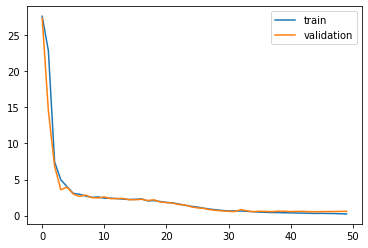

In [18]:
seed_everything()
device = get_default_device()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(names_train, reciprocal_data_train, ys_train,
               L=12.8, N=32, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device)

ml_test = MolLoader(names_test, reciprocal_data_test, ys_test,
                   L=12.8, N=32, batch_size=len(names_test), nchannel=nchannel,
                   shuffle=False, rotate_randomly=False, device=device)

fit(50, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)

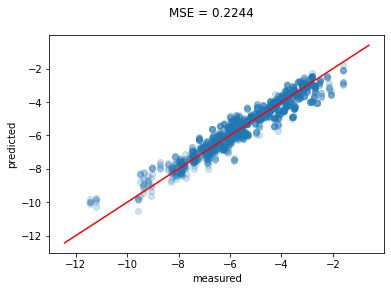

In [19]:
# rotations
seed_everything()
ml_pred = MolLoader(names_train, reciprocal_data_train, ys_train,
                   L=12.8, N=32, batch_size=128, nchannel=nchannel,
                   shuffle=False, rotate_randomly=True, device=device)
predict_plot(ml_pred, epochs=5)

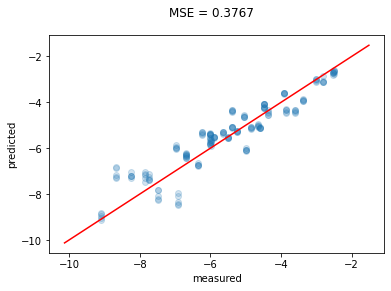

In [20]:
# rotations
seed_everything()
ml_pred = MolLoader(names_test, reciprocal_data_test, ys_test,
                   L=12.8, N=32, batch_size=len(names_test), nchannel=nchannel,
                   shuffle=False, rotate_randomly=True, device=device)
predict_plot(ml_pred, epochs=5)